In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

In [2]:
# Define the dimensions of your video frames
height = 64
width = 64
desired_frames = 30  
channels = 3  

In [3]:
train_dir = 'UCF101/train'
test_dir = 'UCF101/test'

In [4]:
train_csv_path = 'UCF101/train.csv'
train_df = pd.read_csv(train_csv_path)

In [5]:
test_csv_path = 'UCF101/test.csv'
test_df = pd.read_csv(test_csv_path)

In [6]:
train_videos = []
train_labels = []
test_videos = []
test_labels = []

In [7]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    if len(frames) < desired_frames:
        frames.extend([np.zeros((height, width, channels)) for _ in range(desired_frames - len(frames))])
    elif len(frames) > desired_frames:
        frames = frames[:desired_frames]
    return frames

In [8]:
label_map = {}
next_label = 0
for index, row in train_df.iterrows():
    video_path = os.path.join(train_dir, row['video_name'])
    frames = preprocess_video(video_path)
    train_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    train_labels.append(label_map[label])

In [9]:
for index, row in test_df.iterrows():
    video_path = os.path.join(test_dir, row['video_name'])
    frames = preprocess_video(video_path)
    test_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    test_labels.append(label_map[label])

In [10]:
train_videos = np.array(train_videos)
train_labels = np.array(train_labels)
test_videos = np.array(test_videos)
test_labels = np.array(test_labels)

In [11]:
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(desired_frames, height, width, channels)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_videos, train_labels, epochs=10, validation_data=(test_videos, test_labels))

Epoch 1/10
19/19 [==============================] - 159s 8s/step - loss: 1.4866 - accuracy: 0.3350 - val_loss: 1.1062 - val_accuracy: 0.5357
Epoch 2/10
19/19 [==============================] - 158s 8s/step - loss: 0.9272 - accuracy: 0.6431 - val_loss: 1.0621 - val_accuracy: 0.5223
Epoch 3/10
19/19 [==============================] - 151s 8s/step - loss: 0.5709 - accuracy: 0.7997 - val_loss: 0.9119 - val_accuracy: 0.6830
Epoch 4/10
19/19 [==============================] - 154s 8s/step - loss: 0.3889 - accuracy: 0.8552 - val_loss: 1.1471 - val_accuracy: 0.6741
Epoch 5/10
19/19 [==============================] - 151s 8s/step - loss: 0.1555 - accuracy: 0.9343 - val_loss: 1.2959 - val_accuracy: 0.5848
Epoch 6/10
19/19 [==============================] - 155s 8s/step - loss: 0.1045 - accuracy: 0.9596 - val_loss: 1.3222 - val_accuracy: 0.6250
Epoch 7/10
19/19 [==============================] - 154s 8s/step - loss: 0.0917 - accuracy: 0.9815 - val_loss: 1.1601 - val_accuracy: 0.6964
Epoch 8/10
19

In [14]:
test_loss, test_acc = model.evaluate(test_videos, test_labels)
print(f'Test accuracy: {test_acc}')

7/7 [==============================] - 8s 1s/step - loss: 1.8231 - accuracy: 0.6741
Test accuracy: 0.6741071343421936


In [15]:
predictions = model.predict(test_videos)

7/7 [==============================] - 8s 1s/step


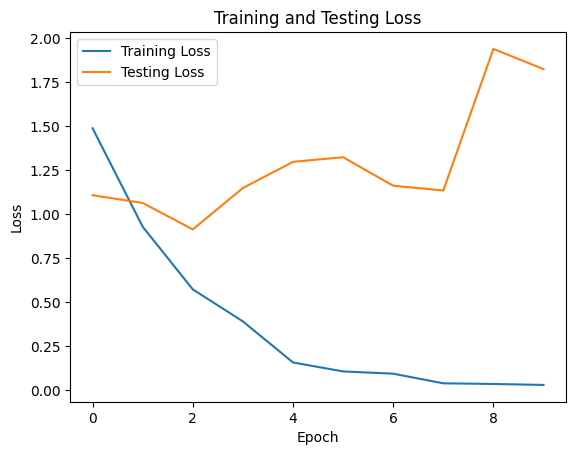

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()